# Understanding Over & Underfitting
## Predicting Boston Housing Prices

## Getting Started
In this project, you will use the Boston Housing Prices dataset to build several models to predict the prices of homes with particular qualities from the suburbs of Boston, MA.
We will build models with several different parameters, which will change the goodness of fit for each. 

---
## Data Exploration
Since we want to predict the value of houses, the **target variable**, `'MEDV'`, will be the variable we seek to predict.

### Import and explore the data. Clean the data for outliers and missing values. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

In [3]:
# Your code here
boston_house = pd.read_csv('/Users/jmpcs/Desktop/Ironhack/Labs/lab-problems-in-ml/data/boston_data.csv')
boston_house.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.15876,0.0,10.81,0.0,0.413,5.961,17.5,5.2873,4.0,305.0,19.2,376.94,9.88,21.7
1,0.10328,25.0,5.13,0.0,0.453,5.927,47.2,6.9320,8.0,284.0,19.7,396.90,9.22,19.6
2,0.34940,0.0,9.90,0.0,0.544,5.972,76.7,3.1025,4.0,304.0,18.4,396.24,9.97,20.3
3,2.73397,0.0,19.58,0.0,0.871,5.597,94.9,1.5257,5.0,403.0,14.7,351.85,21.45,15.4
4,0.04337,21.0,5.64,0.0,0.439,6.115,63.0,6.8147,4.0,243.0,16.8,393.97,9.43,20.5


### Next, we want to explore the data. Pick several varibables you think will be ost correlated with the prices of homes in Boston, and create plots that show the data dispersion as well as the regression line of best fit.

In [5]:
boston_house.shape

(404, 14)

In [4]:
# Your plots here
boston_house.dtypes

crim       float64
zn         float64
indus      float64
chas       float64
nox        float64
rm         float64
age        float64
dis        float64
rad        float64
tax        float64
ptratio    float64
black      float64
lstat      float64
medv       float64
dtype: object

In [6]:
boston_house['medv'].unique()

array([21.7, 19.6, 20.3, 15.4, 20.5, 34.9, 26.2, 21.6, 14.1, 17. , 10.4,
       23.3, 21. , 22.2,  8.7, 23.7, 12. , 21.5,  9.5, 23. , 20.8, 29.4,
       16.5, 16.2, 18.4, 31.1, 21.9, 18.6, 29.1, 36.2, 17.8,  5. , 23.1,
       50. , 29. , 12.7, 35.1, 19.9, 13.8, 23.9, 20.2, 22.6, 19.4, 15.6,
       43.1, 13.4, 13.1, 11.3, 31. , 42.3, 44.8, 25. , 35.2, 24. , 18.2,
       10.2,  7.2, 28.2, 22.9, 34.7, 22. , 22.4, 17.1, 24.1, 19.8, 33.4,
        8.5, 23.2, 16.8, 20.6, 16.4, 43.5, 20. , 13.5, 18.5, 23.4, 35.4,
       19.3, 12.6, 26.6, 32.9, 39.8, 29.6, 30.1, 14. , 24.5, 32.7, 41.3,
       28.7, 19. , 34.6, 20.1, 23.8, 15.1, 16.1, 21.8, 13.9, 30.8, 11.8,
       28.4, 18.9, 21.4, 26.4, 37.2, 24.8, 14.5, 12.3, 17.2, 10.5,  7. ,
       24.7, 37.9, 19.1, 24.4, 37.6, 29.8, 12.1, 27.5,  8.8,  8.4, 22.7,
       11.9, 21.1, 15.2, 18.7, 26.5, 11.5, 30.3, 18.8, 28.6, 27. , 33.1,
       26.7, 13.3,  9.7, 36.5, 33.3, 24.6, 11.7, 13. , 15.3,  8.1, 16.7,
       23.6, 32. , 17.3, 15. , 33.2, 20.9, 21.2, 22

In [7]:
features = boston_house.drop(columns=['medv'])
labels = boston_house['medv']

print(features.head())
print(labels.head())

      crim    zn  indus  chas    nox     rm   age     dis  rad    tax  \
0  0.15876   0.0  10.81   0.0  0.413  5.961  17.5  5.2873  4.0  305.0   
1  0.10328  25.0   5.13   0.0  0.453  5.927  47.2  6.9320  8.0  284.0   
2  0.34940   0.0   9.90   0.0  0.544  5.972  76.7  3.1025  4.0  304.0   
3  2.73397   0.0  19.58   0.0  0.871  5.597  94.9  1.5257  5.0  403.0   
4  0.04337  21.0   5.64   0.0  0.439  6.115  63.0  6.8147  4.0  243.0   

   ptratio   black  lstat  
0     19.2  376.94   9.88  
1     19.7  396.90   9.22  
2     18.4  396.24   9.97  
3     14.7  351.85  21.45  
4     16.8  393.97   9.43  
0    21.7
1    19.6
2    20.3
3    15.4
4    20.5
Name: medv, dtype: float64


### What do these plots tell you about the relationships between these variables and the prices of homes in Boston? Are these the relationships you expected to see in these variables?

In [8]:
# Your response here
boston_house.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.15876,0.0,10.81,0.0,0.413,5.961,17.5,5.2873,4.0,305.0,19.2,376.94,9.88,21.7
1,0.10328,25.0,5.13,0.0,0.453,5.927,47.2,6.9320,8.0,284.0,19.7,396.90,9.22,19.6
2,0.34940,0.0,9.90,0.0,0.544,5.972,76.7,3.1025,4.0,304.0,18.4,396.24,9.97,20.3
3,2.73397,0.0,19.58,0.0,0.871,5.597,94.9,1.5257,5.0,403.0,14.7,351.85,21.45,15.4
4,0.04337,21.0,5.64,0.0,0.439,6.115,63.0,6.8147,4.0,243.0,16.8,393.97,9.43,20.5


### Make a heatmap of the remaining variables. Are there any variables that you did not consider that have very high correlations? What are they?

In [9]:
# Your response here
boston_house[['crim', 'rm', 'age', 'dis', 'tax', 'ptratio', 'lstat', 'medv']].corr()

,crim,rm,age,dis,tax,ptratio,lstat,medv
crim,1.000000,-0.172226,0.349288,-0.376493,0.565047,0.292092,0.428940,-0.400956
rm,-0.172226,1.000000,-0.210589,0.178700,-0.241733,-0.323330,-0.578025,0.683541
age,0.349288,-0.210589,1.000000,-0.734915,0.503830,0.231820,0.602001,-0.390863
dis,-0.376493,0.178700,-0.734915,1.000000,-0.526938,-0.206016,-0.500912,0.264876
tax,0.565047,-0.241733,0.503830,-0.526938,1.000000,0.465997,0.542732,-0.495792
ptratio,0.292092,-0.323330,0.231820,-0.206016,0.465997,1.000000,0.351408,-0.506313
lstat,0.428940,-0.578025,0.602001,-0.500912,0.542732,0.351408,1.000000,-0.742695
medv,-0.400956,0.683541,-0.390863,0.264876,-0.495792,-0.506313,-0.742695,1.000000


C:\Users\jmpcs\AppData\Local\Temp\ipykernel_17240\2191265260.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


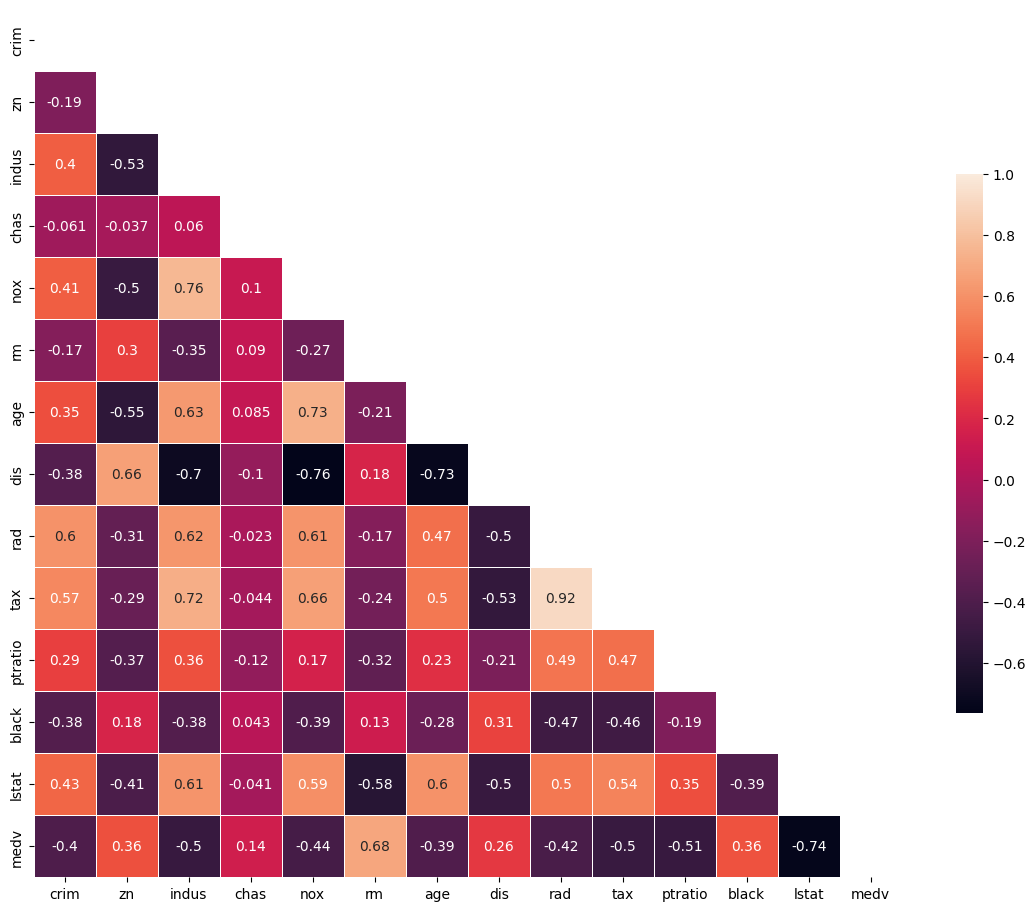

In [12]:
boston_data = pd.concat([features, labels], axis=1)

corr = boston_data.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(14, 14))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask,  vmax=1,square=True, linewidths=.5, cbar_kws={"shrink": .5},annot = corr)

plt.show()

### Calculate Statistics
Calculate descriptive statistics for housing price. Include the minimum, maximum, mean, median, and standard deviation. 

In [13]:
# Your code here
boston_house.describe()


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
count,404.000000,404.000000,404.000000,404.000000,404.000000,404.00000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000
mean,3.730912,10.509901,11.189901,0.069307,0.556710,6.30145,68.601733,3.799666,9.836634,411.688119,18.444554,355.068243,12.598936,22.312376
std,8.943922,22.053733,6.814909,0.254290,0.117321,0.67583,28.066143,2.109916,8.834741,171.073553,2.150295,94.489572,6.925173,8.837019
min,0.006320,0.000000,0.460000,0.000000,0.392000,3.56100,2.900000,1.169100,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082382,0.000000,5.190000,0.000000,0.453000,5.90275,45.800000,2.087875,4.000000,281.000000,17.375000,374.710000,7.135000,17.100000
50%,0.253715,0.000000,9.795000,0.000000,0.538000,6.23050,76.600000,3.207450,5.000000,330.000000,19.000000,391.065000,11.265000,21.400000
75%,4.053158,12.500000,18.100000,0.000000,0.631000,6.62925,94.150000,5.222125,24.000000,666.000000,20.200000,396.007500,16.910000,25.000000
max,88.976200,95.000000,27.740000,1.000000,0.871000,8.78000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,34.370000,50.000000


----

## Developing a Model

### Implementation: Define a Performance Metric
What is the performance meteric with which you will determine the performance of your model? Create a function that calculates this performance metric, and then returns the score. 

In [14]:
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    # Your code here:
    return r2_score(y_true, y_predict)

### Implementation: Shuffle and Split Data
Split the data into the testing and training datasets. Shuffle the data as well to remove any bias in selecting the traing and test. 

In [20]:
# Your code here
from sklearn.model_selection import train_test_split
X = boston_house.drop(labels="medv", axis=1)
Y = boston_house["medv"]

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,train_size=0.25, random_state=42)

----

## Analyzing Model Performance
Next, we are going to build a Random Forest Regressor, and test its performance with several different parameter settings.

### Learning Curves
Lets build the different models. Set the max_depth parameter to 2, 4, 6, 8, and 10 respectively. 

In [21]:
from sklearn.ensemble import RandomForestRegressor

In [22]:
depths = [2, 4, 6, 8, 10]

train_scores = []
test_scores = []

for i in depths:
    # initialize model
    RFR = RandomForestRegressor(max_depth=i)
    # fit
    RFR.fit(X_train, Y_train)
    # predict test
    y_pred_test = RFR.predict(X_test)
    # predict train
    y_pred_train = RFR.predict(X_train)
    
    # get scores
    test_score = performance_metric(Y_test, y_pred_test)
    train_score = performance_metric(Y_train, y_pred_train)
    
    train_scores += [train_score]
    test_scores += [test_score]

Now, plot the score for each tree on the training set and on the testing set.

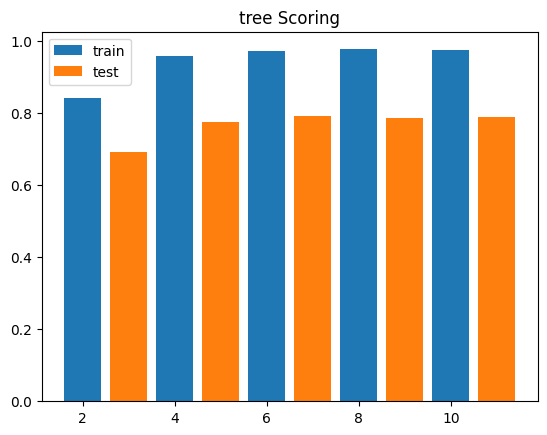

In [23]:
# Produce a plot with the score for the testing and training for the different max depths

plt.bar(x=depths, height=train_scores, label="train")
plt.bar(x=[d+1 for d in depths], height=test_scores, label='test')
plt.title("tree Scoring")
plt.legend()
plt.show()

What do these results tell you about the effect of the depth of the trees on the performance of the model?

In [ ]:
# Your response here

### Bias-Variance Tradeoff
When the model is trained with a maximum depth of 1, does the model suffer from high bias or from high variance? How about when the model is trained with a maximum depth of 10? Check out this article before answering: https://towardsdatascience.com/understanding-the-bias-variance-tradeoff-165e6942b229

In [ ]:
# Your response here
# the model is underpredicting

### Best-Guess Optimal Model
What is the max_depth parameter that you think would optimize the model? Run your model and explain its performance.

In [ ]:
# Your response here

### Applicability
*In a few sentences, discuss whether the constructed model should or should not be used in a real-world setting.*  
**Hint:** Some questions to answering:
- *How relevant today is data that was collected from 1978?*
- *Are the features present in the data sufficient to describe a home?*
- *Is the model robust enough to make consistent predictions?*
- *Would data collected in an urban city like Boston be applicable in a rural city?*

In [ ]:
# Your response here